In [59]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [60]:
env = BlackjackEnv()

In [61]:
def calculate_every_visit_state_value(episode, 
                                      V_every, 
                                      returns_sum_every,
                                      returns_count_every,
                                      discount_factor):
    """
    Helper function to calculate the value of states in an episode
    using every-visit Monte Carlo method
    
    Args:
        episode: list: containing State, Action, Reward transitions in an episode
        V_every: dict: containing estimate of state-value
        
    Returns:
        V_every: dict: containing latest estimate of state-value
    """    
    G = 0
    for (state, action, reward) in reversed(episode):
        G = discount_factor * G + reward
        returns_sum_every[state] += G
        returns_count_every[state] += 1
        V_every[state] = returns_sum_every[state] / returns_count_every[state]
        
    return V_every, returns_sum_every, returns_count_every

def calculate_first_visit_state_value(episode, 
                                      V_first, 
                                      returns_sum_first, 
                                      returns_count_first, 
                                      discount_factor):
    """
    Helper function to calculate the value of states in an episode
    using first-visit Monte Carlo method
    
    Args:
        episode: list: containing State, Action, Reward transitions in an episode
        V_first: dict: containing estimate of state-value
        
    Returns:
        V_first: dict: containing latest estimate of state-value
    """    
    # Create tuples for each state
    unique_states = set([tuple(item[0]) for item in episode])        
    for state in unique_states:
        # Find the index of first occurrence of state in the episode
        state_first_occ_idx = [index for index, SAR in enumerate(episode) if state == SAR[0]][0]            
        # Return from the first occurance of the current state
        G = sum([discount_factor**idx * SAR[2] for idx, SAR in enumerate(episode[state_first_occ_idx:])])
        # Increment the return and counter for the current state and calculate state value
        returns_sum_first[state] += G
        returns_count_first[state] += 1
        V_first[state] = returns_sum_first[state] / returns_count_first[state]
            
    return V_first, returns_sum_first, returns_count_first

In [62]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """   
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_count_first = defaultdict(float)
    returns_sum_first = defaultdict(float)
    returns_count_every = defaultdict(float)
    returns_sum_every = defaultdict(float)
    
    # The final value function
    V_first = defaultdict(float)
    V_every = defaultdict(float)
    
    # Implement this!
    for i_episode in range(num_episodes):
        episode = []
        
        # Generate episode
        state = env.reset()        
        for t in range(100):            
            action = policy(state)            
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:                                
                break
            state = next_state
        
        V_first, returns_sum_first, returns_count_first = calculate_first_visit_state_value(episode, 
                                                                                            V_first, 
                                                                                            returns_sum_first, 
                                                                                            returns_count_first, 
                                                                                            discount_factor)
        
        V_every, returns_sum_every, returns_count_every = calculate_every_visit_state_value(episode, 
                                                                                            V_every, 
                                                                                            returns_sum_every,
                                                                                            returns_count_every,
                                                                                            discount_factor)
        
    return V_first, V_every    

In [63]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

First visit


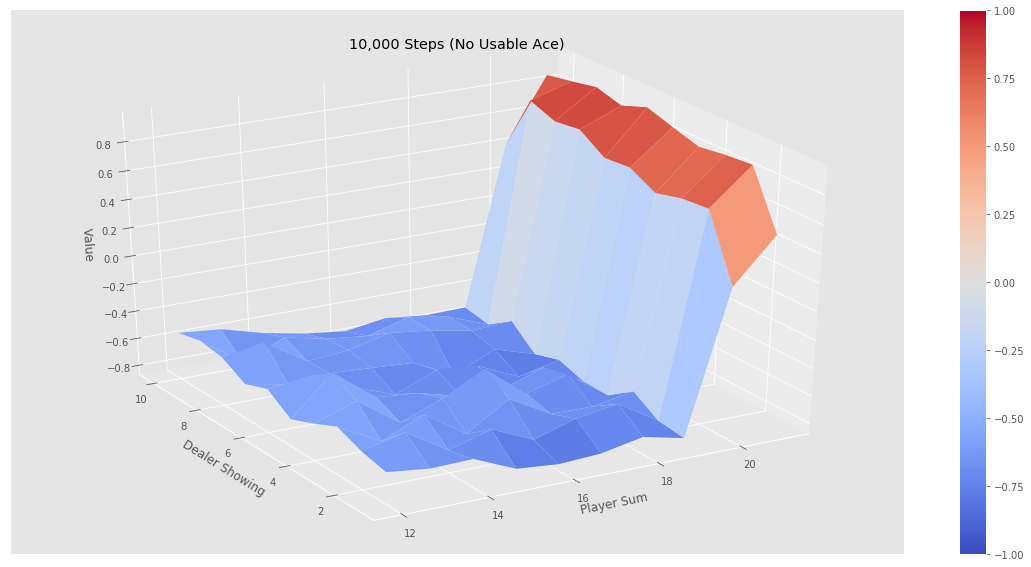

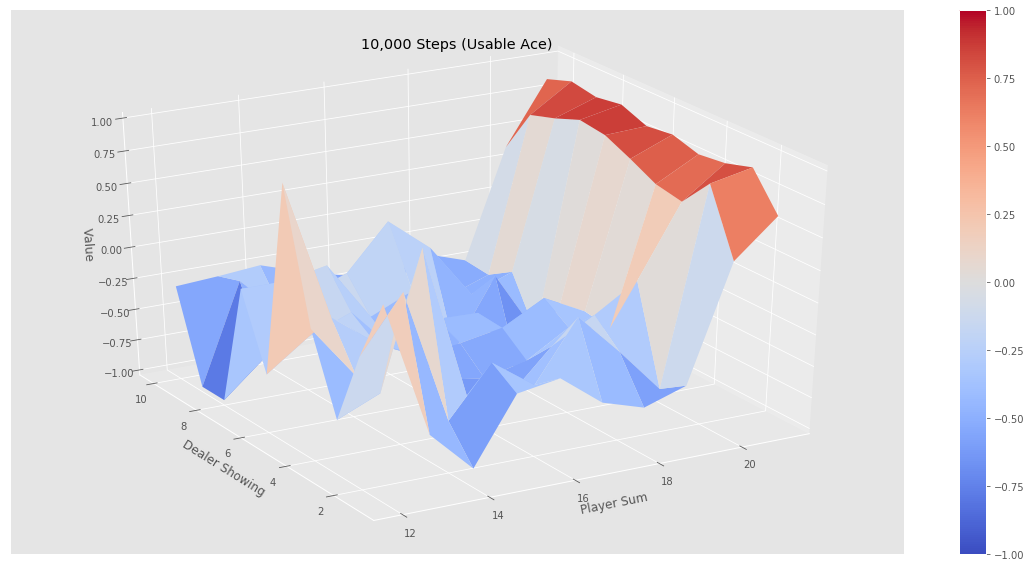

Every visit


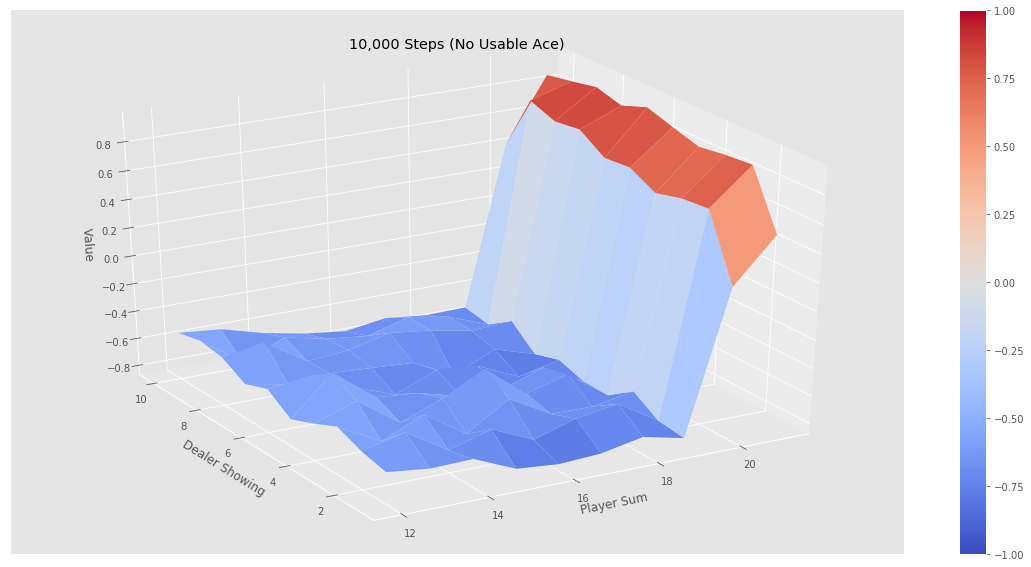

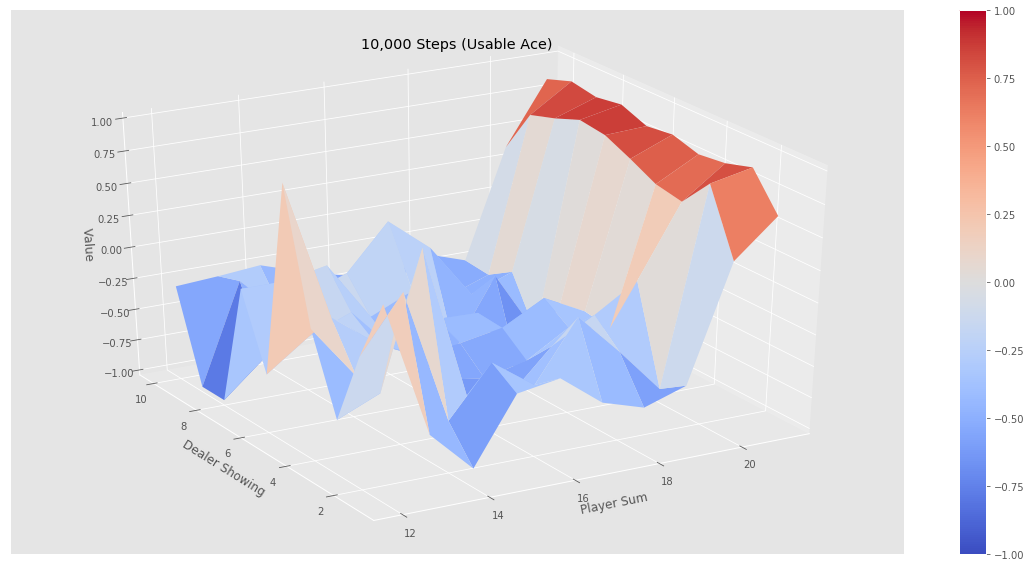

First visit


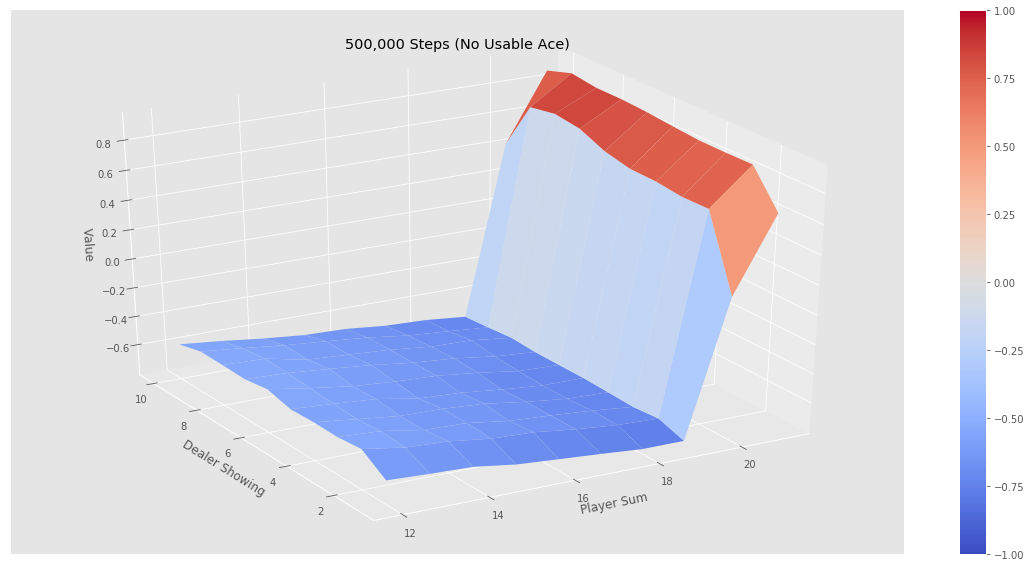

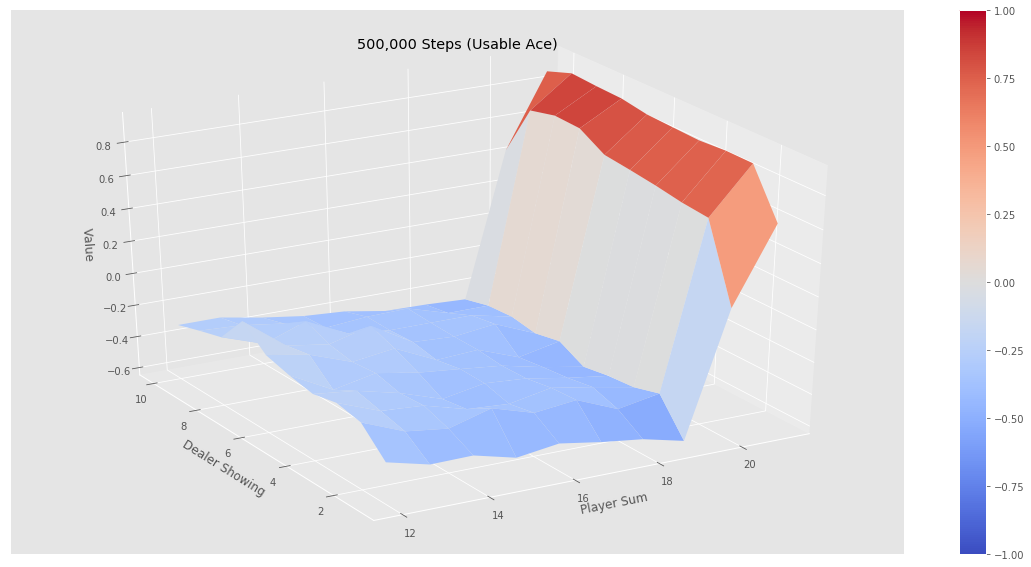

Every visit


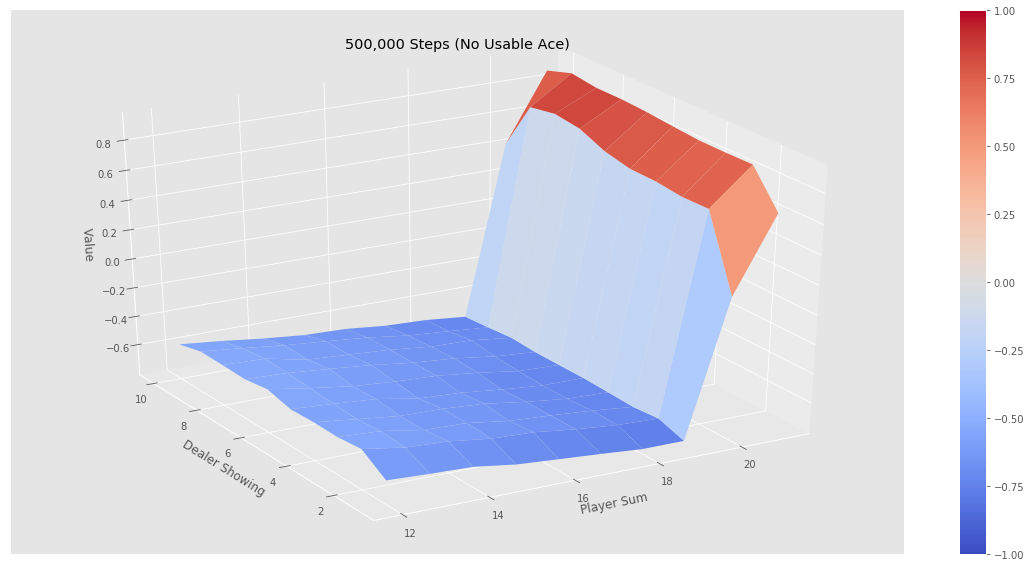

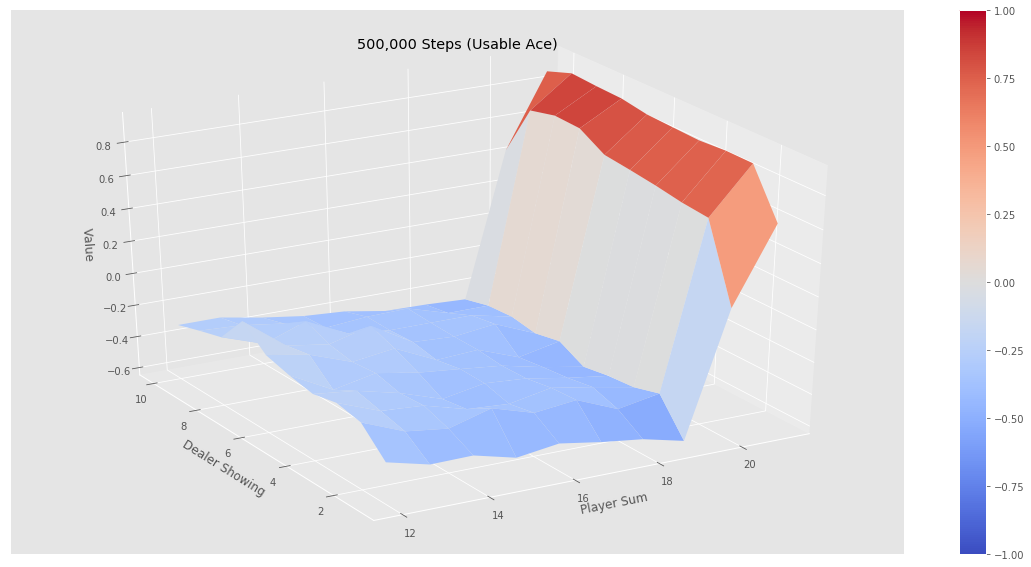

In [64]:
V_first_10k, V_every_10k = mc_prediction(sample_policy, env, num_episodes=10000)
print("First visit")
plotting.plot_value_function(V_first_10k, title="10,000 Steps")
print("Every visit")
plotting.plot_value_function(V_every_10k, title="10,000 Steps")

V_first_500k, V_every_500k = mc_prediction(sample_policy, env, num_episodes=500000)
print("First visit")
plotting.plot_value_function(V_first_500k, title="500,000 Steps")
print("Every visit")
plotting.plot_value_function(V_every_500k, title="500,000 Steps")